# TFG FER

Este notebook contiene el código necesario para la creación de un modelo de clasificación de imágenes de rostros humanos en función del estres emocional que presentan. Para ello, se va a utuilzar un dataset de imágenes pero de tipo .npy que contiene las imágenes de los rostros pero con un formato diferente al habitual, ya que las imágenes están en formato de matriz de píxeles. 

Los pasos a seguir para la creación del modelo son los siguientes:

1. Importar las librerías necesarias
2. Cargar el dataset
3. Preprocesamiento de los datos
4. Creación del modelo
5. Entrenamiento del modelo
6. Evaluación del modelo
7. Guardar el modelo

In [1]:
import os
import tensorflow as tf

# Configurar TensorFlow para que use la CPU
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Ahora, al crear sesiones de TensorFlow, solo se usará la CPU
# Verificar que realmente no estamos utilizando ninguna GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


2024-07-24 16:08:07.563087: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-24 16:08:08.288901: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/fgalan/miniconda3/lib/:/home/fgalan/miniconda3/lib/:/home/fgalan/miniconda3/envs/myenv/lib/
2024-07-24 16:08:08.289006: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/fgalan/miniconda3/lib/:/

Num GPUs Available:  2


2024-07-24 16:08:09.331267: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-24 16:08:09.331541: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-24 16:08:09.345764: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-24 16:08:09.346005: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-24 16:08:09.346220: I tensorflow/compiler/xla/stream_executo

## 1. Importar las librerías necesarias

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
import random

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Comprobar version tensorflow
print(tf.__version__)

# Comprobar que estamos usando la GPU
print(tf.config.list_physical_devices())

2.11.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


## 2. Cargar el dataset

Como se ha mencionado anteriormente, el dataset que se va a utilizar se basa en archivos de tipo .npy que contiene las imágenes de los rostros en formato de matriz de píxeles. Para cargar el dataset, se utiliza la función `np.load()` de la librería NumPy.

Para la recolección de imágenes se ha utilizado un dataset cuyo escenario experimental consiste en pasos que causan o no causan estrés; lectura de escritura en el idioma nativo, entrevista en el idioma nativo, lectura de escritura en idioma no nativo, entrevista en idioma no nativo.

Por lo tanto las distintas carpetas que forma el dataset son:

- **Native_Language_Script_Reading and Non_Native_Language_Script_Reading** (ESTRES-NEUTRAL)
- **Native_Language_Interview** (BAJO ESTRES)
- **Non_Native_Language_Interview** (ALTO ESTRES)

Para procesar archivos .npy de la manera que se ha descrito y asignar las etiquetas correspondientes (como "NEUTRAL-STRESS", "LOW-STRESS" y "HIGH-STRESS") se va a utilizar el nombre de la carpeta en la que se encuentran.

Se van a seguir los siguientes pasos:

### 2.1 Asignar las etiquetas a las imágenes

Para asignar las etiquetas a las imágenes, se va a utilizar una primero una función que recorra las carpetas del dataset y asigne las etiquetas correspondientes a cada imagen.

In [3]:
def asignar_etiqueta(nombre_carpeta):
    if nombre_carpeta == "Native_Language_Script_Reading" or nombre_carpeta == "Non-native_Language_Script_Reading":
        return "ESTRES-NEUTRAL"
    elif nombre_carpeta == "Native_Language_Interview":
        return "BAJO ESTRES"
    elif nombre_carpeta == "Non-native_Language_Interview":
        return "ALTO ESTRES"
    else:
        return None  # Por si el nombre de la carpeta no coincide

### 2.2 Cargar las imágenes y las etiquetas

Para el dataset que se va a utilizar, se van a cargar las imágenes de distintas carpetas, segun la persona que aparece en la imagen, y las etiquetas correspondientes a cada imagen. Dentro de cada carpeta de cada persona, se encuentran las carpetas con las clases de estrés correspondientes, y dentro de cada una de estas carpetas se encuentran las imágenes. Lo que se va a realizar es cargar las imágenes y las etiquetas de cada una de las carpetas de las clases de estrés, y se van a guardar todas las corresponientes a cada persona en un array de numpy. Para asi tener un array de numpy con todas las imágenes y otro con todas las etiquetas.

Es importante destacar que se va a añadir otra lista llamada sujetos, que contendrá el nombre de la persona a la que pertenece cada imagen. Esto se va a realizar para poder separar el dataset en train y test de manera que no se mezclen las imágenes de una misma persona en ambos conjuntos.

In [4]:
# Definir la ruta base de tu DATASET
ruta = "DATASET"
# Definir las subcarpetas que corresponden a cada clase
classes = ["Native_Language_Script_Reading", "Native_Language_Interview",
           "Non-native_Language_Script_Reading", "Non-native_Language_Interview"]

# Definir las etiquetas correspondientes para las clases
etiquetas_clases = {
    "Native_Language_Script_Reading": "ESTRES NEUTRAL",
    "Non-native_Language_Script_Reading": "ESTRES NEUTRAL",
    "Native_Language_Interview": "BAJO ESTRES",
    "Non-native_Language_Interview": "ALTO ESTRES"
}


# Número deseado de imágenes por clase
num_images_per_class = 750

# Listas para almacenar las rutas de las imágenes, las etiquetas y los sujetos
imagenes = []
etiquetas = []
sujetos = []

# Recorrer cada persona en el dataset
for carpeta_persona in sorted(os.listdir(ruta)):
    ruta_persona = os.path.join(ruta, carpeta_persona)
    print(ruta_persona)
    if os.path.isdir(ruta_persona):  # Asegurar que es un directorio
        # Recorrer cada clase
        for cls in classes:
            ruta_clase = os.path.join(ruta_persona, cls)
            if os.path.exists(ruta_clase):
                # Lista todas las imágenes (archivos .npy) en la carpeta de la clase
                images = [os.path.join(ruta_clase, img) for img in sorted(os.listdir(ruta_clase)) if img.endswith(".npy")]
                etiqueta = etiquetas_clases[cls]

                # Reducir el número de imágenes si supera el límite deseado
                if len(images) >= num_images_per_class:
                    if etiqueta == "ESTRES NEUTRAL":
                        # Limitar al 50% de num_images_per_class si es "NEUTRAL-STRESS"
                        max_images = num_images_per_class // 2
                    else:
                        max_images = num_images_per_class

                    selected_images = random.sample(images, max_images)
                else:
                    selected_images = images

                # Añadir las rutas de las imágenes seleccionadas y sus etiquetas a las listas
                for ruta_imagen in selected_images:
                    imagenes.append(ruta_imagen)
                    etiquetas.append(etiqueta)
                    sujetos.append(carpeta_persona)

# Contar etiquetas por clase
conteo_etiquetas = {etiqueta: etiquetas.count(etiqueta) for etiqueta in set(etiquetas)}

# Número de etiquetas creadas por clase
for etiqueta, conteo in conteo_etiquetas.items():
    print(f"Etiqueta '{etiqueta}': {conteo} imágenes")

# Comprobar que se cargaron las rutas de las imágenes correctamente en la lista de sujetos
conteo_sujetos = {sujeto: sujetos.count(sujeto) for sujeto in set(sujetos)}
# Ordenar los sujetos antes de imprimir
for sujeto in sorted(conteo_sujetos.keys(), key=lambda x: int(x)):
    conteo = conteo_sujetos[sujeto]
    print(f"Sujeto '{sujeto}': {conteo} imágenes")

# Comprobar que las etiquetas se asignaron a las rutas de las imágenes correctamente
for i in range(1000):
    print(f"Imagen con ruta '{imagenes[i]}' tiene etiqueta '{etiquetas[i]}' y sujeto '{sujetos[i]}'")



DATASET/01
DATASET/02
DATASET/03
DATASET/04
DATASET/05


DATASET/06
DATASET/07
DATASET/08
DATASET/09
DATASET/10
DATASET/11
DATASET/12
DATASET/13
DATASET/14
DATASET/15
DATASET/16
DATASET/17
DATASET/18
DATASET/19
DATASET/20
DATASET/21
DATASET/22
DATASET/23
DATASET/24
DATASET/25
DATASET/27
DATASET/28
DATASET/29
DATASET/30
DATASET/31
DATASET/32
DATASET/33
DATASET/34
DATASET/35
DATASET/36
DATASET/37
DATASET/38
DATASET/39
DATASET/40
DATASET/41
DATASET/42
DATASET/43
DATASET/44
DATASET/45
DATASET/46
DATASET/47
DATASET/48
DATASET/49
DATASET/50
Etiqueta 'ESTRES NEUTRAL': 36750 imágenes
Etiqueta 'BAJO ESTRES': 36750 imágenes
Etiqueta 'ALTO ESTRES': 36750 imágenes
Sujeto '01': 2250 imágenes
Sujeto '02': 2250 imágenes
Sujeto '03': 2250 imágenes
Sujeto '04': 2250 imágenes
Sujeto '05': 2250 imágenes
Sujeto '06': 2250 imágenes
Sujeto '07': 2250 imágenes
Sujeto '08': 2250 imágenes
Sujeto '09': 2250 imágenes
Sujeto '10': 2250 imágenes
Sujeto '11': 2250 imágenes
Sujeto '12': 2250 imágenes
Sujeto '13': 2250 imágenes
Sujeto '14': 2250 imágenes
Sujeto '15': 2250 

#### 2.2.3 Comprobar que no existen imágenes repetidas

In [5]:
# Comprobar que no existen imágenes duplicadas
import hashlib

def hash_image(file_path):
    # Cargar la imagen
    image = np.load(file_path, allow_pickle=True)
    # Convertir la imagen a bytes
    image_bytes = image.tobytes()
    return hashlib.sha256(image_bytes).hexdigest()

hashes = set()
duplicates = []

# Recorrer cada imagen y calcular su hash, para comprobar si hay duplicados
for image_path in imagenes:
    image_hash = hash_image(image_path)
    if image_hash in hashes:
        duplicates.append(image_path)
    else:
        hashes.add(image_hash)

print(f"Se encontraron {len(duplicates)} imágenes duplicadas.")
print(f"Se encontraron {len(hashes)} imágenes únicas.")


Se encontraron 0 imágenes duplicadas.
Se encontraron 110250 imágenes únicas.


### 2.3 Visualizar las imágenes

Antes de continuar con el preprocesamiento de los datos, se van a visualizar algunas de las imágenes del dataset para comprobar que se han cargado correctamente.

In [6]:
# Comprobar que se han cargado las imágenes
print("Número de imágenes cargadas:", len(imagenes))
print("Número de etiquetas cargadas:", len(etiquetas))
print("Número de sujetos cargados:", len(sujetos))


Número de imágenes cargadas: 110250
Número de etiquetas cargadas: 110250
Número de sujetos cargados: 110250


Vamos a visualizar el número de imágenes que hay en cada categoría

In [7]:
# Contar cuántas imágenes hay de cada etiqueta
from collections import Counter

conteo = Counter(etiquetas)
print("Número de imágenes por etiqueta:", conteo)  

Número de imágenes por etiqueta: Counter({'ESTRES NEUTRAL': 36750, 'BAJO ESTRES': 36750, 'ALTO ESTRES': 36750})


### 2.4 Preprocesamiento de los datos

Una vez que se han cargado las imágenes y las etiquetas, se van a preprocesar los datos para poder utilizarlos en el modelo de clasificación. Para ello, se van a seguir los siguientes pasos:

- Crear un generador de imágenes con tf.data.Dataset para cargar las imágenes en lotes
- Normalizar las imágenes
- Dividir los datos en conjuntos de entrenamiento y prueba
- Codificar las etiquetas

#### 2.4.1 Generador de imágenes

In [8]:
import tensorflow as tf

def load_npy_file(file_path):
    # Cargar el archivo npy
    image = np.load(file_path, allow_pickle=True)
    # Normalizar la imagen
    image = image.astype('float32') / 255.0
    return image

# Mapear etiquetas de texto a valores numéricos
etiquetas_dict = {'ESTRES NEUTRAL': 0, 'BAJO ESTRES': 1, 'ALTO ESTRES': 2}
etiquetas_numericas = np.array([etiquetas_dict[label] for label in etiquetas])


#### 2.4.2 Dividir los datos en conjuntos de entrenamiento y prueba

Dividimos el conjunto de entrenamiento, conjunto de test y conjunto de validación, con una proporción de 3:1:1 respectivamente.

In [9]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Convertir etiquetas a one-hot encoding
etiquetas_one_hot = to_categorical(etiquetas_numericas)

# Crear una lista de sujetos únicos
sujetos_unicos = sorted(set(sujetos))
print("Número de sujetos:", len(sujetos_unicos))

# Dividir los sujetos en conjuntos de entrenamiento, validación y prueba
train_suj, test_val_suj = train_test_split(sujetos_unicos, test_size=0.4, random_state=42)
val_suj, test_suj = train_test_split(test_val_suj, test_size=0.5, random_state=42)

# Función para asignar conjunto basado en el sujeto
def asignar_conjunto(sujeto):
    if sujeto in train_suj:
        return 'train'
    elif sujeto in val_suj:
        return 'val'
    else:
        return 'test'

# Asignar cada imagen a un conjunto
conjuntos = np.array([asignar_conjunto(s) for s in sujetos])

# Separar las imágenes y etiquetas en los conjuntos
X_train_paths = np.array(imagenes)[conjuntos == 'train']
y_train = etiquetas_one_hot[conjuntos == 'train']
X_val_paths = np.array(imagenes)[conjuntos == 'val']
y_val = etiquetas_one_hot[conjuntos == 'val']
X_test_paths = np.array(imagenes)[conjuntos == 'test']
y_test = etiquetas_one_hot[conjuntos == 'test']

# Imprimir las formas de los arrays para verificar
print("Datos de entrenamiento:", X_train_paths.shape, y_train.shape)
print("Datos de validación:", X_val_paths.shape, y_val.shape)
print("Datos de prueba:", X_test_paths.shape, y_test.shape)

# Ver cuales son los sujetos que se encuentran en cada conjunto
print("Sujetos de entrenamiento:", sorted(train_suj))
print("Sujetos de validación:", sorted(val_suj))
print("Sujetos de prueba:", sorted(test_suj))


Número de sujetos: 49
Datos de entrenamiento: (65250,) (65250, 3)
Datos de validación: (22500,) (22500, 3)
Datos de prueba: (22500,) (22500, 3)
Sujetos de entrenamiento: ['01', '02', '03', '06', '08', '10', '11', '12', '15', '17', '19', '21', '22', '23', '24', '25', '30', '31', '32', '34', '35', '37', '38', '39', '40', '41', '44', '45', '50']
Sujetos de validación: ['04', '09', '13', '16', '18', '20', '27', '28', '36', '49']
Sujetos de prueba: ['05', '07', '14', '29', '33', '42', '43', '46', '47', '48']


Esta manera de dividir los datos nos va a permitir entrenar el modelo con el conjunto de entrenamiento, ajustar los hiperparámetros con el conjunto de validación y evaluar el modelo con el conjunto de prueba.

Tambien es crucial para evitar el overfitting, ya que si entrenamos y evaluamos el modelo con el mismo conjunto de datos, el modelo puede aprender a predecir las etiquetas de ese conjunto de datos en lugar de generalizar a nuevos datos.

## 3. Creación del modelo

Una vez que se han preprocesado los datos, se va a crear el modelo de clasificación de imágenes de rostros humanos en función del estrés emocional que presentan. Para ello, se va a utilizar una red neuronal densa que consta de varias capas totalmente conectadas.

### 3.1 Definición de los modelos

En este apartado se van a explicar los modelos que se van a utilizar para la clasificación de los datos. Todos los modelos que se muestran en este apartado son redes neuronales densas que constan de varias se componen únicamente de capas densas, que conectan todas las neuronas de una capa con las de la siguiente, y son capaces de aprender relaciones complejas en los datos sin depender de la estructura espacial. Este enfoque permitirá construir un modelo eficiente y efectivo, adaptado a las características específicas de nuestros datos

#### 3.1.1 Modelo 1

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Reshape, Dropout, BatchNormalization, Add, Input

# Crear el modelo
def create_model_1(input_shape, num_classes):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model


# Definir la entrada y el número de clases
input_shape = (256, 7, 7)  # Actualizar según sea necesario
num_classes = 3  # Cambiar según el número de clases en tu dataset

#### Compilar y entrenar el modelo

In [11]:
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Configurar validación cruzada con 5 divisiones
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Variables para almacenar los resultados de la validación cruzada
fold_no = 1
acc_per_fold = []
loss_per_fold = []

# Función para cargar imágenes desde rutas antes de entrenar el modelo
def cargar_imagenes(rutas):
    imagenes = [load_npy_file(ruta) for ruta in rutas]
    return np.array(imagenes)

# Validación cruzada, iterar sobre cada división
for train_index, val_index in kf.split(X_train_paths):
    print(f"Fold número {fold_no}")
    # Usar las divisiones correctas para el entrenamiento y la validación
    X_train_fold_paths, X_val_fold_paths = X_train_paths[train_index], X_train_paths[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    # Cargar las imágenes
    X_train_fold = cargar_imagenes(X_train_fold_paths)
    X_val_fold = cargar_imagenes(X_val_fold_paths)
    
    # Comprobar que las formas son correctas
    print(X_train_fold.shape, y_train_fold.shape)
    print(X_val_fold.shape, y_val_fold.shape)

    # Crear el modelo
    model = create_model_1(input_shape, num_classes)
    
    # Compilar el modelo
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Entrenar el modelo y validar con los datos de validación
    print(f'Training fold {fold_no}...')
    history = model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, validation_data=(X_val_fold, y_val_fold), shuffle=True)
    
    # Evaluar el modelo con los datos de test
    X_test = cargar_imagenes(X_test_paths)
    scores = model.evaluate(X_test, y_test, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Incrementar el número de la división
    fold_no += 1

Fold número 1


(52200, 256, 7, 7) (52200, 3)
(13050, 256, 7, 7) (13050, 3)


2024-07-24 16:09:19.280000: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-24 16:09:19.593264: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-24 16:09:19.593514: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-24 16:09:19.593733: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

Training fold 1...


2024-07-24 16:09:21.907984: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2619187200 exceeds 10% of free system memory.


Epoch 1/10


2024-07-24 16:09:23.992899: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-07-24 16:09:24.004950: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f53014584f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-24 16:09:24.004964: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-07-24 16:09:24.004969: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2024-07-24 16:09:24.008382: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-24 16:09:24.101316: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is 

1632/1632 [==============================] - 7s 3ms/step - loss: 0.0689 - accuracy: 0.9754 - val_loss: 0.0353 - val_accuracy: 0.9882
Epoch 2/10
1632/1632 [==============================] - 4s 3ms/step - loss: 0.0332 - accuracy: 0.9884 - val_loss: 0.0291 - val_accuracy: 0.9905
Epoch 3/10
1632/1632 [==============================] - 4s 3ms/step - loss: 0.0289 - accuracy: 0.9900 - val_loss: 0.0185 - val_accuracy: 0.9939
Epoch 4/10
1632/1632 [==============================] - 4s 3ms/step - loss: 0.0224 - accuracy: 0.9920 - val_loss: 0.0191 - val_accuracy: 0.9943
Epoch 5/10
1632/1632 [==============================] - 4s 3ms/step - loss: 0.0211 - accuracy: 0.9929 - val_loss: 0.0174 - val_accuracy: 0.9946
Epoch 6/10
1632/1632 [==============================] - 4s 3ms/step - loss: 0.0184 - accuracy: 0.9933 - val_loss: 0.0180 - val_accuracy: 0.9945
Epoch 7/10
1632/1632 [==============================] - 5s 3ms/step - loss: 0.0177 - accuracy: 0.9939 - val_loss: 0.0197 - val_accuracy: 0.9938
Epo

2024-07-24 16:10:14.380060: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1128960000 exceeds 10% of free system memory.
2024-07-24 16:10:15.039853: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1128960000 exceeds 10% of free system memory.


Score for fold 1: loss of 0.1758883148431778; accuracy of 97.25333452224731%
Fold número 2
(52200, 256, 7, 7) (52200, 3)
(13050, 256, 7, 7) (13050, 3)
Training fold 2...


2024-07-24 16:10:27.971877: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2619187200 exceeds 10% of free system memory.


Epoch 1/10
1632/1632 [==============================] - 6s 3ms/step - loss: 0.0717 - accuracy: 0.9734 - val_loss: 0.0231 - val_accuracy: 0.9920
Epoch 2/10
1632/1632 [==============================] - 4s 3ms/step - loss: 0.0329 - accuracy: 0.9885 - val_loss: 0.0169 - val_accuracy: 0.9943
Epoch 3/10
1632/1632 [==============================] - 5s 3ms/step - loss: 0.0299 - accuracy: 0.9899 - val_loss: 0.0183 - val_accuracy: 0.9936
Epoch 4/10
1632/1632 [==============================] - 5s 3ms/step - loss: 0.0229 - accuracy: 0.9917 - val_loss: 0.0131 - val_accuracy: 0.9962
Epoch 5/10
1632/1632 [==============================] - 5s 3ms/step - loss: 0.0211 - accuracy: 0.9927 - val_loss: 0.0157 - val_accuracy: 0.9945
Epoch 6/10
1632/1632 [==============================] - 5s 3ms/step - loss: 0.0189 - accuracy: 0.9935 - val_loss: 0.0148 - val_accuracy: 0.9952
Epoch 7/10
1632/1632 [==============================] - 5s 3ms/step - loss: 0.0170 - accuracy: 0.9941 - val_loss: 0.0233 - val_accuracy:

#### Validación del modelo


In [12]:
# Mostrar los resultados de la validación cruzada
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

# Reiniciar las variables para almacenar los resultados de la validación cruzada de otro modelo
fold_no = 1
acc_per_fold = []
loss_per_fold = []

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.1758883148431778 - Accuracy: 97.25333452224731%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.1489339917898178 - Accuracy: 97.18666672706604%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.18746867775917053 - Accuracy: 97.04889059066772%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.10349943488836288 - Accuracy: 97.7733314037323%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.10763251036405563 - Accuracy: 97.59111404418945%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 97.37066745758057 (+- 0.2690347894611537)
> Loss: 0.14468458592891692
-------------------------

#### Visualización de Matriz de Confusión

En esta parte se genera matrices de confusión para los conjuntos de entrenamiento, validación y prueba, y también muestra algunas imágenes de cada etiqueta para confirmar que las etiquetas corresponden correctamente.
Gracias a la matriz de confusión, podemos ver cómo se comporta nuestro modelo en cada clase, y si hay alguna clase que se confunda con otra, lo que nos va a demostrar si el modelo está aprendiendo correctamente.

##### Función para dibujar la matriz de confusión

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    #This function prints and plots the confusion matrix.
    #Normalization can be applied by setting `normalize=True`.

    if not isinstance(cm, np.ndarray) or cm.ndim != 2:
        raise ValueError("La matriz de confusión debe ser un array 2D.")
    
    # Se utiliza .imshow para mostrar la matriz de confusión como una imagen, donde el color de cada celda representa el valor de la celda
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    # Se configuran las marcas (ticks) de los ejes X e Y para mostrar los nombres de las clases
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Se calcula un umbral para decidir el color del texto (blanco o negro) 
    # basado en el color de fondo de la celda para mejorar la legibilidad
    thresh = cm.max() / 2.
    # Se itera sobre cada elemento de la matriz de confusión, comprobando que cada elemento sea un escalar y 
    # se anota el valor de cada celda en el gráfico
    for i, j in np.ndindex(cm.shape):
        if isinstance(cm[i, j], np.ndarray):
            raise ValueError("Los elementos de la matriz de confusión deben ser escalares.")
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


##### Calcular la matriz de confusión

704/704 [==============================] - 1s 1ms/step
Orden de las clases: {'ESTRES NEUTRAL': 0, 'BAJO ESTRES': 1, 'ALTO ESTRES': 2}


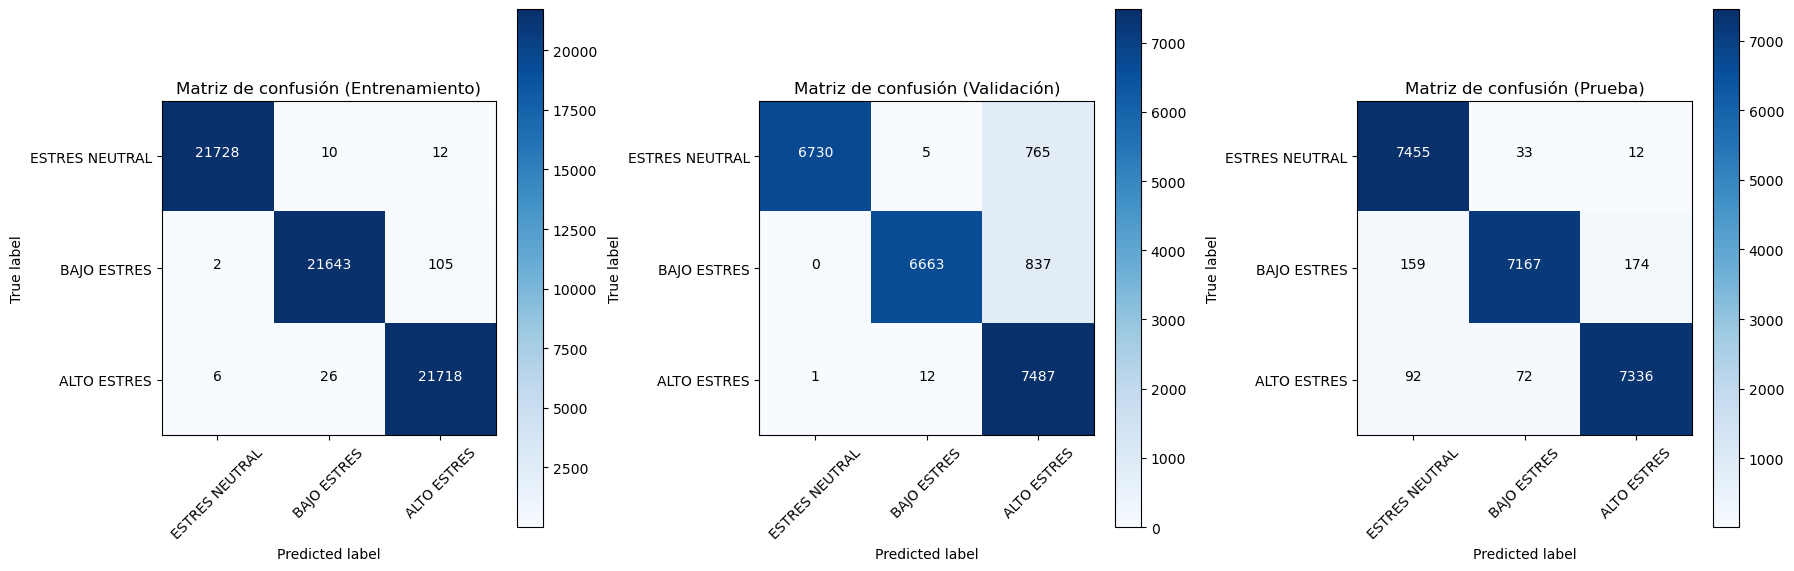

In [14]:
# Declaramos las variables 
y_pred_train = model.predict(cargar_imagenes(X_train_paths))
y_pred_val = model.predict(cargar_imagenes(X_val_paths))
y_pred_test = model.predict(cargar_imagenes(X_test_paths))

# Convertir las predicciones de probabilidades a etiquetas
y_pred_train_labels = np.argmax(y_pred_train, axis=1)
y_pred_val_labels = np.argmax(y_pred_val, axis=1)
y_pred_test_labels = np.argmax(y_pred_test, axis=1)

# Etiquetas verdaderas
y_true_train = np.argmax(y_train, axis=1)
y_true_val = np.argmax(y_val, axis=1)
y_true_test = np.argmax(y_test, axis=1)


# Calcular matrices de confusión
cm_train = confusion_matrix(y_true_train, y_pred_train_labels)
cm_val = confusion_matrix(y_true_val, y_pred_val_labels)
cm_test = confusion_matrix(y_true_test, y_pred_test_labels)

# Comprobar el orden de las clases
print("Orden de las clases:", etiquetas_dict)

# Dibujar matrices de confusión
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plot_confusion_matrix(cm_train, classes=['ESTRES NEUTRAL', 'BAJO ESTRES', 'ALTO ESTRES'], title='Matriz de confusión (Entrenamiento)')
plt.subplot(1, 3, 2)
plot_confusion_matrix(cm_val, classes=['ESTRES NEUTRAL', 'BAJO ESTRES', 'ALTO ESTRES'], title='Matriz de confusión (Validación)')
plt.subplot(1, 3, 3)
plot_confusion_matrix(cm_test, classes=['ESTRES NEUTRAL', 'BAJO ESTRES', 'ALTO ESTRES'], title='Matriz de confusión (Prueba)')


In [15]:
# Entrenar el modelo final con todo el conjunto de entrenamiento
X_train_final = cargar_imagenes(X_train_paths)
y_train_final = y_train

# Crear el modelo final
model_final = create_model_1(input_shape, num_classes)

# Compilar el modelo final
model_final.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo final
model_final.fit(X_train_final, y_train_final, epochs=10, batch_size=32, shuffle=True)

# Guardar el modelo final en el formato SavedModel en la carpeta 'modelos'
model_save_path = os.path.join("modelos", 'modelo_final_1.h5')
model_final.save(model_save_path)

Epoch 1/10
2040/2040 [==============================] - 5s 2ms/step - loss: 0.0628 - accuracy: 0.9770
Epoch 2/10
2040/2040 [==============================] - 5s 2ms/step - loss: 0.0337 - accuracy: 0.9887
Epoch 3/10
2040/2040 [==============================] - 5s 3ms/step - loss: 0.0256 - accuracy: 0.9912
Epoch 4/10
2040/2040 [==============================] - 5s 2ms/step - loss: 0.0214 - accuracy: 0.9927
Epoch 5/10
2040/2040 [==============================] - 5s 3ms/step - loss: 0.0201 - accuracy: 0.9934
Epoch 6/10
2040/2040 [==============================] - 5s 2ms/step - loss: 0.0177 - accuracy: 0.9940
Epoch 7/10
2040/2040 [==============================] - 5s 2ms/step - loss: 0.0166 - accuracy: 0.9943
Epoch 8/10
2040/2040 [==============================] - 5s 2ms/step - loss: 0.0154 - accuracy: 0.9950
Epoch 9/10
2040/2040 [==============================] - 5s 2ms/step - loss: 0.0139 - accuracy: 0.9952
Epoch 10/10
2040/2040 [==============================] - 5s 2ms/step - loss: 0.012

#### 3.1.2 Modelo 2

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Convertir etiquetas a one-hot encoding
etiquetas_one_hot = to_categorical(etiquetas_numericas)

# Crear una lista de sujetos únicos
sujetos_unicos = sorted(set(sujetos))
print("Número de sujetos:", len(sujetos_unicos))

# Dividir los sujetos en conjuntos de entrenamiento, validación y prueba
train_suj, test_val_suj = train_test_split(sujetos_unicos, test_size=0.4, random_state=42)
val_suj, test_suj = train_test_split(test_val_suj, test_size=0.5, random_state=42)

# Función para asignar conjunto basado en el sujeto
def asignar_conjunto(sujeto):
    if sujeto in train_suj:
        return 'train'
    elif sujeto in val_suj:
        return 'val'
    else:
        return 'test'

# Asignar cada imagen a un conjunto
conjuntos = np.array([asignar_conjunto(s) for s in sujetos])

# Separar las imágenes y etiquetas en los conjuntos
X_train_paths = np.array(imagenes)[conjuntos == 'train']
y_train = etiquetas_one_hot[conjuntos == 'train']
X_val_paths = np.array(imagenes)[conjuntos == 'val']
y_val = etiquetas_one_hot[conjuntos == 'val']
X_test_paths = np.array(imagenes)[conjuntos == 'test']
y_test = etiquetas_one_hot[conjuntos == 'test']

# Imprimir las formas de los arrays para verificar
print("Datos de entrenamiento:", X_train_paths.shape, y_train.shape)
print("Datos de validación:", X_val_paths.shape, y_val.shape)
print("Datos de prueba:", X_test_paths.shape, y_test.shape)

# Ver cuales son los sujetos que se encuentran en cada conjunto
print("Sujetos de entrenamiento:", sorted(train_suj))
print("Sujetos de validación:", sorted(val_suj))
print("Sujetos de prueba:", sorted(test_suj))


Número de sujetos: 49
Datos de entrenamiento: (65250,) (65250, 3)
Datos de validación: (22500,) (22500, 3)
Datos de prueba: (22500,) (22500, 3)
Sujetos de entrenamiento: ['01', '02', '03', '06', '08', '10', '11', '12', '15', '17', '19', '21', '22', '23', '24', '25', '30', '31', '32', '34', '35', '37', '38', '39', '40', '41', '44', '45', '50']
Sujetos de validación: ['04', '09', '13', '16', '18', '20', '27', '28', '36', '49']
Sujetos de prueba: ['05', '07', '14', '29', '33', '42', '43', '46', '47', '48']


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Función para crear un modelo con capas ajustadas
def create_model_2(input_shape, num_classes):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

input_shape = (256, 7, 7)  # Actualizar según sea necesario
num_classes = 3  # Cambiar según el número de clases en tu dataset

In [ ]:
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Configurar validación cruzada con 5 divisiones
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Variables para almacenar los resultados de la validación cruzada
fold_no = 1
acc_per_fold = []
loss_per_fold = []

# Función para cargar imágenes desde rutas antes de entrenar el modelo
def cargar_imagenes(rutas):
    imagenes = [load_npy_file(ruta) for ruta in rutas]
    return np.array(imagenes)

# Validación cruzada, iterar sobre cada división
for train_index, val_index in kf.split(X_train_paths):
    print(f"Fold número {fold_no}")
    # Usar las divisiones correctas para el entrenamiento y la validación
    X_train_fold_paths, X_val_fold_paths = X_train_paths[train_index], X_train_paths[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    # Cargar las imágenes
    X_train_fold = cargar_imagenes(X_train_fold_paths)
    X_val_fold = cargar_imagenes(X_val_fold_paths)
    
    # Comprobar que las formas son correctas
    print(X_train_fold.shape, y_train_fold.shape)
    print(X_val_fold.shape, y_val_fold.shape)

    # Crear el modelo
    model = create_model_2(input_shape, num_classes)
    
    # Compilar el modelo
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Entrenar el modelo y validar con los datos de validación
    print(f'Training fold {fold_no}...')
    history = model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, validation_data=(X_val_fold, y_val_fold), shuffle=True)
    
    # Evaluar el modelo con los datos de test
    X_test = cargar_imagenes(X_test_paths)
    scores = model.evaluate(X_test, y_test, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Incrementar el número de la división
    fold_no += 1

Fold número 1


(52200, 256, 7, 7) (52200, 3)
(13050, 256, 7, 7) (13050, 3)


2024-07-24 14:33:56.846238: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-24 14:33:57.147164: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-24 14:33:57.147417: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-24 14:33:57.147635: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

Training fold 1...


2024-07-24 14:33:59.466788: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2619187200 exceeds 10% of free system memory.


Epoch 1/10


2024-07-24 14:34:01.642129: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-07-24 14:34:01.646797: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x55d7b86ec080 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-24 14:34:01.646824: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-07-24 14:34:01.646832: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2024-07-24 14:34:01.651326: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-24 14:34:01.749691: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is 

1632/1632 [==============================] - 8s 4ms/step - loss: 0.0784 - accuracy: 0.9709 - val_loss: 0.0272 - val_accuracy: 0.9916
Epoch 2/10
1632/1632 [==============================] - 6s 4ms/step - loss: 0.0425 - accuracy: 0.9856 - val_loss: 0.0256 - val_accuracy: 0.9914
Epoch 3/10
1632/1632 [==============================] - 6s 3ms/step - loss: 0.0360 - accuracy: 0.9887 - val_loss: 0.0351 - val_accuracy: 0.9900
Epoch 4/10
1632/1632 [==============================] - 6s 3ms/step - loss: 0.0316 - accuracy: 0.9900 - val_loss: 0.0244 - val_accuracy: 0.9933
Epoch 5/10
1632/1632 [==============================] - 6s 4ms/step - loss: 0.0263 - accuracy: 0.9913 - val_loss: 0.0400 - val_accuracy: 0.9875
Epoch 6/10
1632/1632 [==============================] - 6s 3ms/step - loss: 0.0279 - accuracy: 0.9909 - val_loss: 0.0357 - val_accuracy: 0.9874
Epoch 7/10
1632/1632 [==============================] - 6s 3ms/step - loss: 0.0268 - accuracy: 0.9915 - val_loss: 0.0195 - val_accuracy: 0.9946
Epo

2024-07-24 14:35:04.027850: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1128960000 exceeds 10% of free system memory.
2024-07-24 14:35:04.698010: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1128960000 exceeds 10% of free system memory.


Score for fold 1: loss of 0.16188009083271027; accuracy of 97.75111079216003%
Fold número 2
(52200, 256, 7, 7) (52200, 3)
(13050, 256, 7, 7) (13050, 3)
Training fold 2...


2024-07-24 14:35:18.923869: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2619187200 exceeds 10% of free system memory.


Epoch 1/10
1632/1632 [==============================] - 7s 4ms/step - loss: 0.0781 - accuracy: 0.9710 - val_loss: 0.0310 - val_accuracy: 0.9895
Epoch 2/10
1632/1632 [==============================] - 6s 3ms/step - loss: 0.0432 - accuracy: 0.9860 - val_loss: 0.0243 - val_accuracy: 0.9928
Epoch 3/10
1632/1632 [==============================] - 6s 3ms/step - loss: 0.0365 - accuracy: 0.9889 - val_loss: 0.0195 - val_accuracy: 0.9936
Epoch 4/10
1632/1632 [==============================] - 6s 4ms/step - loss: 0.0307 - accuracy: 0.9902 - val_loss: 0.0214 - val_accuracy: 0.9936
Epoch 5/10
1632/1632 [==============================] - 6s 3ms/step - loss: 0.0288 - accuracy: 0.9909 - val_loss: 0.0179 - val_accuracy: 0.9945
Epoch 6/10
1632/1632 [==============================] - 6s 3ms/step - loss: 0.0261 - accuracy: 0.9918 - val_loss: 0.0213 - val_accuracy: 0.9945
Epoch 7/10
1632/1632 [==============================] - 6s 4ms/step - loss: 0.0241 - accuracy: 0.9926 - val_loss: 0.0195 - val_accuracy:

In [ ]:
# Mostrar los resultados de la validación cruzada
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

# Reiniciar las variables para almacenar los resultados de la validación cruzada de otro modelo
fold_no = 1
acc_per_fold = []
loss_per_fold = []

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.16188009083271027 - Accuracy: 97.75111079216003%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.1394215226173401 - Accuracy: 97.61777520179749%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.1299852579832077 - Accuracy: 97.84444570541382%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.14141659438610077 - Accuracy: 97.680002450943%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.10387645661830902 - Accuracy: 98.11555743217468%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 97.8017783164978 (+- 0.17408707314756883)
> Loss: 0.13531598448753357
--------------------------

704/704 [==============================] - 1s 1ms/step


704/704 [==============================] - 1s 1ms/step
Orden de las clases: {'ESTRES NEUTRAL': 0, 'BAJO ESTRES': 1, 'ALTO ESTRES': 2}


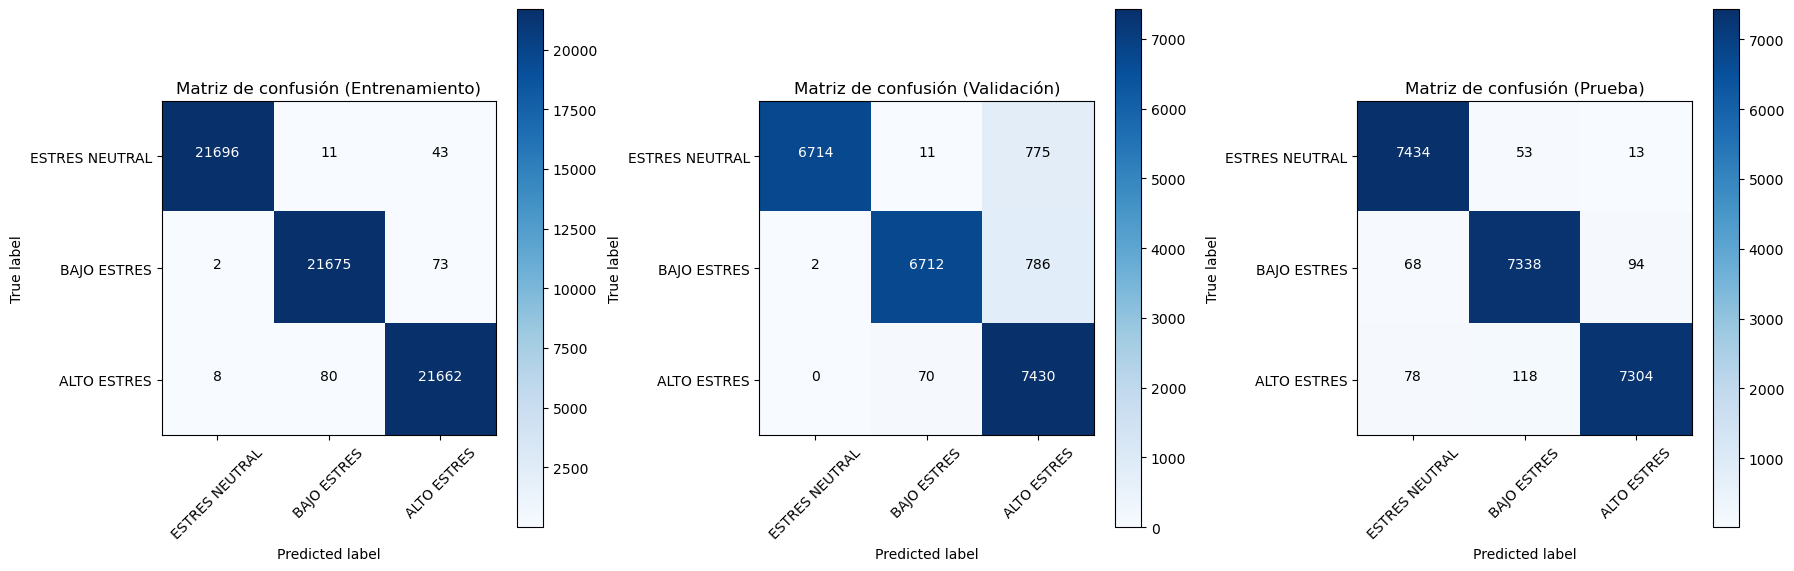

In [ ]:
# Asumiendo que tienes 'model' ya entrenado y 'X_train', 'X_val', 'X_test', 'y_train', 'y_val', 'y_test' definidos
y_pred_train = model.predict(cargar_imagenes(X_train_paths))
y_pred_val = model.predict(cargar_imagenes(X_val_paths))
y_pred_test = model.predict(cargar_imagenes(X_test_paths))

# Convertir las predicciones de probabilidades a etiquetas
y_pred_train_labels = np.argmax(y_pred_train, axis=1)
y_pred_val_labels = np.argmax(y_pred_val, axis=1)
y_pred_test_labels = np.argmax(y_pred_test, axis=1)

# Etiquetas verdaderas
y_true_train = np.argmax(y_train, axis=1)
y_true_val = np.argmax(y_val, axis=1)
y_true_test = np.argmax(y_test, axis=1)


# Calcular matrices de confusión
cm_train = confusion_matrix(y_true_train, y_pred_train_labels)
cm_val = confusion_matrix(y_true_val, y_pred_val_labels)
cm_test = confusion_matrix(y_true_test, y_pred_test_labels)

# Comprobar el orden de las clases
print("Orden de las clases:", etiquetas_dict)

# Dibujar matrices de confusión
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plot_confusion_matrix(cm_train, classes=['ESTRES NEUTRAL', 'BAJO ESTRES', 'ALTO ESTRES'], title='Matriz de confusión (Entrenamiento)')
plt.subplot(1, 3, 2)
plot_confusion_matrix(cm_val, classes=['ESTRES NEUTRAL', 'BAJO ESTRES', 'ALTO ESTRES'], title='Matriz de confusión (Validación)')
plt.subplot(1, 3, 3)
plot_confusion_matrix(cm_test, classes=['ESTRES NEUTRAL', 'BAJO ESTRES', 'ALTO ESTRES'], title='Matriz de confusión (Prueba)')

In [ ]:
# Entrenar el modelo final con todo el conjunto de entrenamiento
X_train_final = cargar_imagenes(X_train_paths)
y_train_final = y_train

# Crear el modelo final
model_final = create_model_2(input_shape, num_classes)

# Compilar el modelo final
model_final.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo final
model_final.fit(X_train_final, y_train_final, epochs=10, batch_size=32, shuffle=True)

# Guardar el modelo final en el formato SavedModel en la carpeta 'modelos'
model_save_path = os.path.join("modelos", 'modelo_final_2.h5')
model_final.save(model_save_path)

Epoch 1/10
2040/2040 [==============================] - 7s 3ms/step - loss: 0.0738 - accuracy: 0.9726
Epoch 2/10
2040/2040 [==============================] - 6s 3ms/step - loss: 0.0415 - accuracy: 0.9868
Epoch 3/10
1875/2040 [==========================>...] - ETA: 0s - loss: 0.0325 - accuracy: 0.9899

2040/2040 [==============================] - 6s 3ms/step - loss: 0.0324 - accuracy: 0.9897
Epoch 4/10
2040/2040 [==============================] - 6s 3ms/step - loss: 0.0303 - accuracy: 0.9905
Epoch 5/10
2040/2040 [==============================] - 6s 3ms/step - loss: 0.0273 - accuracy: 0.9912
Epoch 6/10
2040/2040 [==============================] - 6s 3ms/step - loss: 0.0252 - accuracy: 0.9920
Epoch 7/10
2040/2040 [==============================] - 6s 3ms/step - loss: 0.0242 - accuracy: 0.9924
Epoch 8/10
2040/2040 [==============================] - 6s 3ms/step - loss: 0.0233 - accuracy: 0.9929
Epoch 9/10
2040/2040 [==============================] - 6s 3ms/step - loss: 0.0222 - accuracy: 0.9936
Epoch 10/10
2040/2040 [==============================] - 6s 3ms/step - loss: 0.0218 - accuracy: 0.9929


#### 3.1.3 Modelo 3

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Convertir etiquetas a one-hot encoding
etiquetas_one_hot = to_categorical(etiquetas_numericas)

# Crear una lista de sujetos únicos
sujetos_unicos = sorted(set(sujetos))
print("Número de sujetos:", len(sujetos_unicos))

# Dividir los sujetos en conjuntos de entrenamiento, validación y prueba
train_suj, test_val_suj = train_test_split(sujetos_unicos, test_size=0.4, random_state=42)
val_suj, test_suj = train_test_split(test_val_suj, test_size=0.5, random_state=42)

# Función para asignar conjunto basado en el sujeto
def asignar_conjunto(sujeto):
    if sujeto in train_suj:
        return 'train'
    elif sujeto in val_suj:
        return 'val'
    else:
        return 'test'

# Asignar cada imagen a un conjunto
conjuntos = np.array([asignar_conjunto(s) for s in sujetos])

# Separar las imágenes y etiquetas en los conjuntos
X_train_paths = np.array(imagenes)[conjuntos == 'train']
y_train = etiquetas_one_hot[conjuntos == 'train']
X_val_paths = np.array(imagenes)[conjuntos == 'val']
y_val = etiquetas_one_hot[conjuntos == 'val']
X_test_paths = np.array(imagenes)[conjuntos == 'test']
y_test = etiquetas_one_hot[conjuntos == 'test']

# Imprimir las formas de los arrays para verificar
print("Datos de entrenamiento:", X_train_paths.shape, y_train.shape)
print("Datos de validación:", X_val_paths.shape, y_val.shape)
print("Datos de prueba:", X_test_paths.shape, y_test.shape)

# Ver cuales son los sujetos que se encuentran en cada conjunto
print("Sujetos de entrenamiento:", sorted(train_suj))
print("Sujetos de validación:", sorted(val_suj))
print("Sujetos de prueba:", sorted(test_suj))



Número de sujetos: 49
Datos de entrenamiento: (65250,) (65250, 3)
Datos de validación: (22500,) (22500, 3)
Datos de prueba: (22500,) (22500, 3)
Sujetos de entrenamiento: ['01', '02', '03', '06', '08', '10', '11', '12', '15', '17', '19', '21', '22', '23', '24', '25', '30', '31', '32', '34', '35', '37', '38', '39', '40', '41', '44', '45', '50']
Sujetos de validación: ['04', '09', '13', '16', '18', '20', '27', '28', '36', '49']
Sujetos de prueba: ['05', '07', '14', '29', '33', '42', '43', '46', '47', '48']


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Add, Input

# Función para crear un modelo con capas ajustadas
def create_model_3(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Flatten()(inputs)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Bloque residual
    residual = x
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Add()([x, residual])

    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model


input_shape = (256, 7, 7)  # Actualizar según sea necesario
num_classes = 3  # Cambiar según el número de clases en tu dataset

In [ ]:
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Configurar validación cruzada con 5 divisiones
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Variables para almacenar los resultados de la validación cruzada
fold_no = 1
acc_per_fold = []
loss_per_fold = []

# Función para cargar imágenes desde rutas antes de entrenar el modelo
def cargar_imagenes(rutas):
    imagenes = [load_npy_file(ruta) for ruta in rutas]
    return np.array(imagenes)

# Validación cruzada, iterar sobre cada división
for train_index, val_index in kf.split(X_train_paths):
    print(f"Fold número {fold_no}")
    # Usar las divisiones correctas para el entrenamiento y la validación
    X_train_fold_paths, X_val_fold_paths = X_train_paths[train_index], X_train_paths[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    # Cargar las imágenes
    X_train_fold = cargar_imagenes(X_train_fold_paths)
    X_val_fold = cargar_imagenes(X_val_fold_paths)
    
    # Comprobar que las formas son correctas
    print(X_train_fold.shape, y_train_fold.shape)
    print(X_val_fold.shape, y_val_fold.shape)

    # Crear el modelo
    model = create_model_3(input_shape, num_classes)
    
    # Compilar el modelo
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Entrenar el modelo y validar con los datos de validación
    print(f'Training fold {fold_no}...')
    history = model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, validation_data=(X_val_fold, y_val_fold), shuffle=True)
    
    # Evaluar el modelo con los datos de test
    X_test = cargar_imagenes(X_test_paths)
    scores = model.evaluate(X_test, y_test, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Incrementar el número de la división
    fold_no += 1

Fold número 1


(52200, 256, 7, 7) (52200, 3)
(13050, 256, 7, 7) (13050, 3)


2024-07-23 20:02:01.901361: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-23 20:02:02.233827: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-23 20:02:02.234111: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-23 20:02:02.234363: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

Training fold 1...


2024-07-23 20:02:04.637007: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2619187200 exceeds 10% of free system memory.


Epoch 1/10


2024-07-23 20:02:06.907317: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-07-23 20:02:06.912631: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f21dfc990b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-23 20:02:06.912645: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-07-23 20:02:06.912652: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2024-07-23 20:02:06.915991: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-23 20:02:07.059483: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is 

1632/1632 [==============================] - 8s 4ms/step - loss: 0.0782 - accuracy: 0.9711 - val_loss: 0.0230 - val_accuracy: 0.9925
Epoch 2/10
1632/1632 [==============================] - 5s 3ms/step - loss: 0.0399 - accuracy: 0.9868 - val_loss: 0.0200 - val_accuracy: 0.9931
Epoch 3/10
1632/1632 [==============================] - 5s 3ms/step - loss: 0.0361 - accuracy: 0.9884 - val_loss: 0.0171 - val_accuracy: 0.9943
Epoch 4/10
1632/1632 [==============================] - 5s 3ms/step - loss: 0.0290 - accuracy: 0.9899 - val_loss: 0.0168 - val_accuracy: 0.9940
Epoch 5/10
1632/1632 [==============================] - 5s 3ms/step - loss: 0.0260 - accuracy: 0.9917 - val_loss: 0.0196 - val_accuracy: 0.9943
Epoch 6/10
1632/1632 [==============================] - 5s 3ms/step - loss: 0.0264 - accuracy: 0.9918 - val_loss: 0.0170 - val_accuracy: 0.9942
Epoch 7/10
1632/1632 [==============================] - 5s 3ms/step - loss: 0.0232 - accuracy: 0.9929 - val_loss: 0.0225 - val_accuracy: 0.9925
Epo

2024-07-23 20:03:19.669615: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2619187200 exceeds 10% of free system memory.
2024-07-23 20:03:21.168813: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2619187200 exceeds 10% of free system memory.


Epoch 1/10
1632/1632 [==============================] - 7s 4ms/step - loss: 0.0765 - accuracy: 0.9716 - val_loss: 0.0273 - val_accuracy: 0.9903
Epoch 2/10
1632/1632 [==============================] - 5s 3ms/step - loss: 0.0382 - accuracy: 0.9870 - val_loss: 0.0214 - val_accuracy: 0.9926
Epoch 3/10
1632/1632 [==============================] - 5s 3ms/step - loss: 0.0325 - accuracy: 0.9893 - val_loss: 0.0180 - val_accuracy: 0.9943
Epoch 4/10
1632/1632 [==============================] - 5s 3ms/step - loss: 0.0307 - accuracy: 0.9906 - val_loss: 0.0179 - val_accuracy: 0.9946
Epoch 5/10
1632/1632 [==============================] - 5s 3ms/step - loss: 0.0269 - accuracy: 0.9913 - val_loss: 0.0221 - val_accuracy: 0.9931
Epoch 6/10
1632/1632 [==============================] - 5s 3ms/step - loss: 0.0235 - accuracy: 0.9925 - val_loss: 0.0167 - val_accuracy: 0.9952
Epoch 7/10
1632/1632 [==============================] - 5s 3ms/step - loss: 0.0228 - accuracy: 0.9926 - val_loss: 0.0166 - val_accuracy:

2024-07-23 20:04:35.381623: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2619187200 exceeds 10% of free system memory.


Epoch 1/10
1632/1632 [==============================] - 7s 4ms/step - loss: 0.0761 - accuracy: 0.9711 - val_loss: 0.0276 - val_accuracy: 0.9910
Epoch 2/10
1632/1632 [==============================] - 5s 3ms/step - loss: 0.0391 - accuracy: 0.9869 - val_loss: 0.0232 - val_accuracy: 0.9924
Epoch 3/10
1632/1632 [==============================] - 5s 3ms/step - loss: 0.0315 - accuracy: 0.9899 - val_loss: 0.0230 - val_accuracy: 0.9926
Epoch 4/10
1632/1632 [==============================] - 5s 3ms/step - loss: 0.0283 - accuracy: 0.9910 - val_loss: 0.0216 - val_accuracy: 0.9947
Epoch 5/10
1632/1632 [==============================] - 5s 3ms/step - loss: 0.0269 - accuracy: 0.9913 - val_loss: 0.0210 - val_accuracy: 0.9942
Epoch 6/10
1632/1632 [==============================] - 5s 3ms/step - loss: 0.0238 - accuracy: 0.9921 - val_loss: 0.0358 - val_accuracy: 0.9912
Epoch 7/10
1632/1632 [==============================] - 5s 3ms/step - loss: 0.0229 - accuracy: 0.9927 - val_loss: 0.0256 - val_accuracy:

In [ ]:
# Mostrar los resultados de la validación cruzada
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

# Reiniciar las variables para almacenar los resultados de la validación cruzada de otro modelo
fold_no = 1
acc_per_fold = []
loss_per_fold = []

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.15711702406406403 - Accuracy: 98.07111024856567%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.12020797282457352 - Accuracy: 97.9022204875946%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.1434221714735031 - Accuracy: 97.28888869285583%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.126437246799469 - Accuracy: 98.10222387313843%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.23228245973587036 - Accuracy: 96.28000259399414%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 97.52888917922974 (+- 0.6898420922671711)
> Loss: 0.155893374979496
----------------------------

704/704 [==============================] - 1s 1ms/step
Orden de las clases: {'ESTRES NEUTRAL': 0, 'BAJO ESTRES': 1, 'ALTO ESTRES': 2}


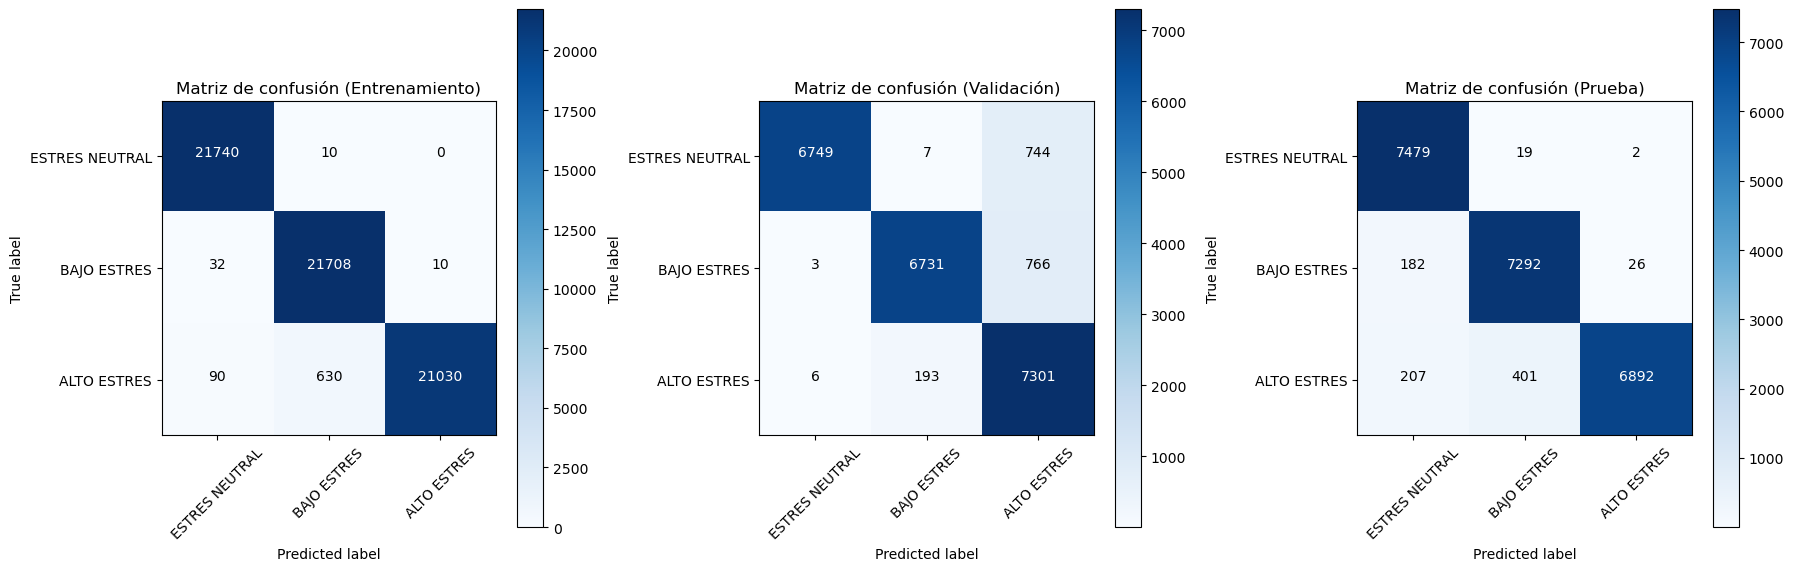

In [ ]:
# Asumiendo que tienes 'model' ya entrenado y 'X_train', 'X_val', 'X_test', 'y_train', 'y_val', 'y_test' definidos
y_pred_train = model.predict(cargar_imagenes(X_train_paths))
y_pred_val = model.predict(cargar_imagenes(X_val_paths))
y_pred_test = model.predict(cargar_imagenes(X_test_paths))

# Convertir las predicciones de probabilidades a etiquetas
y_pred_train_labels = np.argmax(y_pred_train, axis=1)
y_pred_val_labels = np.argmax(y_pred_val, axis=1)
y_pred_test_labels = np.argmax(y_pred_test, axis=1)

# Etiquetas verdaderas
y_true_train = np.argmax(y_train, axis=1)
y_true_val = np.argmax(y_val, axis=1)
y_true_test = np.argmax(y_test, axis=1)


# Calcular matrices de confusión
cm_train = confusion_matrix(y_true_train, y_pred_train_labels)
cm_val = confusion_matrix(y_true_val, y_pred_val_labels)
cm_test = confusion_matrix(y_true_test, y_pred_test_labels)

# Comprobar el orden de las clases
print("Orden de las clases:", etiquetas_dict)

# Dibujar matrices de confusión
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plot_confusion_matrix(cm_train, classes=['ESTRES NEUTRAL', 'BAJO ESTRES', 'ALTO ESTRES'], title='Matriz de confusión (Entrenamiento)')
plt.subplot(1, 3, 2)
plot_confusion_matrix(cm_val, classes=['ESTRES NEUTRAL', 'BAJO ESTRES', 'ALTO ESTRES'], title='Matriz de confusión (Validación)')
plt.subplot(1, 3, 3)
plot_confusion_matrix(cm_test, classes=['ESTRES NEUTRAL', 'BAJO ESTRES', 'ALTO ESTRES'], title='Matriz de confusión (Prueba)')

In [ ]:
# Entrenar el modelo final con todo el conjunto de entrenamiento
X_train_final = cargar_imagenes(X_train_paths)
y_train_final = y_train

# Crear el modelo final
model_final = create_model_3(input_shape, num_classes)

# Compilar el modelo final
model_final.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo final
model_final.fit(X_train_final, y_train_final, epochs=10, batch_size=32, shuffle=True)

# Guardar el modelo final en el formato SavedModel en la carpeta 'modelos'
model_save_path = os.path.join("modelos", 'modelo_final_3.h5')
model_final.save(model_save_path)

Epoch 1/10
2040/2040 [==============================] - 7s 3ms/step - loss: 0.0702 - accuracy: 0.9742
Epoch 2/10
2040/2040 [==============================] - 6s 3ms/step - loss: 0.0374 - accuracy: 0.9875
Epoch 3/10
2040/2040 [==============================] - 6s 3ms/step - loss: 0.0318 - accuracy: 0.9896
Epoch 4/10
2040/2040 [==============================] - 6s 3ms/step - loss: 0.0271 - accuracy: 0.9915
Epoch 5/10
2040/2040 [==============================] - 6s 3ms/step - loss: 0.0250 - accuracy: 0.9919
Epoch 6/10
2040/2040 [==============================] - 6s 3ms/step - loss: 0.0224 - accuracy: 0.9923
Epoch 7/10
2040/2040 [==============================] - 6s 3ms/step - loss: 0.0235 - accuracy: 0.9928
Epoch 8/10
2040/2040 [==============================] - 6s 3ms/step - loss: 0.0193 - accuracy: 0.9938
Epoch 9/10
2040/2040 [==============================] - 6s 3ms/step - loss: 0.0221 - accuracy: 0.9932
Epoch 10/10
2040/2040 [==============================] - 6s 3ms/step - loss: 0.018

#### 3.1.4 Modelo 4

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Convertir etiquetas a one-hot encoding
etiquetas_one_hot = to_categorical(etiquetas_numericas)

# Crear una lista de sujetos únicos
sujetos_unicos = sorted(set(sujetos))
print("Número de sujetos:", len(sujetos_unicos))

# Dividir los sujetos en conjuntos de entrenamiento, validación y prueba
train_suj, test_val_suj = train_test_split(sujetos_unicos, test_size=0.4, random_state=42)
val_suj, test_suj = train_test_split(test_val_suj, test_size=0.5, random_state=42)

# Función para asignar conjunto basado en el sujeto
def asignar_conjunto(sujeto):
    if sujeto in train_suj:
        return 'train'
    elif sujeto in val_suj:
        return 'val'
    else:
        return 'test'

# Asignar cada imagen a un conjunto
conjuntos = np.array([asignar_conjunto(s) for s in sujetos])

# Separar las imágenes y etiquetas en los conjuntos
X_train_paths = np.array(imagenes)[conjuntos == 'train']
y_train = etiquetas_one_hot[conjuntos == 'train']
X_val_paths = np.array(imagenes)[conjuntos == 'val']
y_val = etiquetas_one_hot[conjuntos == 'val']
X_test_paths = np.array(imagenes)[conjuntos == 'test']
y_test = etiquetas_one_hot[conjuntos == 'test']

# Imprimir las formas de los arrays para verificar
print("Datos de entrenamiento:", X_train_paths.shape, y_train.shape)
print("Datos de validación:", X_val_paths.shape, y_val.shape)
print("Datos de prueba:", X_test_paths.shape, y_test.shape)

# Ver cuales son los sujetos que se encuentran en cada conjunto
print("Sujetos de entrenamiento:", sorted(train_suj))
print("Sujetos de validación:", sorted(val_suj))
print("Sujetos de prueba:", sorted(test_suj))



Número de sujetos: 49
Datos de entrenamiento: (65250,) (65250, 3)
Datos de validación: (22500,) (22500, 3)
Datos de prueba: (22500,) (22500, 3)
Sujetos de entrenamiento: ['01', '02', '03', '06', '08', '10', '11', '12', '15', '17', '19', '21', '22', '23', '24', '25', '30', '31', '32', '34', '35', '37', '38', '39', '40', '41', '44', '45', '50']
Sujetos de validación: ['04', '09', '13', '16', '18', '20', '27', '28', '36', '49']
Sujetos de prueba: ['05', '07', '14', '29', '33', '42', '43', '46', '47', '48']


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization

# Función para crear un modelo con capas ajustadas
def create_model_4(input_shape, num_classes):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(512, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model


input_shape = (256, 7, 7)  # Actualizar según sea necesario
num_classes = 3  # Cambiar según el número de clases en tu dataset

In [ ]:
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Configurar validación cruzada con 5 divisiones
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Variables para almacenar los resultados de la validación cruzada
fold_no = 1
acc_per_fold = []
loss_per_fold = []

# Función para cargar imágenes desde rutas antes de entrenar el modelo
def cargar_imagenes(rutas):
    imagenes = [load_npy_file(ruta) for ruta in rutas]
    return np.array(imagenes)

# Validación cruzada, iterar sobre cada división
for train_index, val_index in kf.split(X_train_paths):
    print(f"Fold número {fold_no}")
    # Usar las divisiones correctas para el entrenamiento y la validación
    X_train_fold_paths, X_val_fold_paths = X_train_paths[train_index], X_train_paths[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    # Cargar las imágenes
    X_train_fold = cargar_imagenes(X_train_fold_paths)
    X_val_fold = cargar_imagenes(X_val_fold_paths)
    
    # Comprobar que las formas son correctas
    print(X_train_fold.shape, y_train_fold.shape)
    print(X_val_fold.shape, y_val_fold.shape)

    # Crear el modelo
    model = create_model_4(input_shape, num_classes)
    
    # Compilar el modelo
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Entrenar el modelo y validar con los datos de validación
    print(f'Training fold {fold_no}...')
    history = model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, validation_data=(X_val_fold, y_val_fold), shuffle=True)
    
    # Evaluar el modelo con los datos de test
    X_test = cargar_imagenes(X_test_paths)
    scores = model.evaluate(X_test, y_test, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Incrementar el número de la división
    fold_no += 1

Fold número 1


(52200, 256, 7, 7) (52200, 3)
(13050, 256, 7, 7) (13050, 3)


2024-07-23 17:56:28.475551: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-23 17:56:28.821220: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-23 17:56:28.821471: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-23 17:56:28.821690: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

Training fold 1...


2024-07-23 17:56:29.688822: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2619187200 exceeds 10% of free system memory.
2024-07-23 17:56:31.202748: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2619187200 exceeds 10% of free system memory.


Epoch 1/10


2024-07-23 17:56:33.594877: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-07-23 17:56:33.610188: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f9b42bafa50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-23 17:56:33.610202: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-07-23 17:56:33.610207: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2024-07-23 17:56:33.622732: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-23 17:56:33.809303: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is 

1632/1632 [==============================] - 9s 4ms/step - loss: 0.0678 - accuracy: 0.9791 - val_loss: 0.0178 - val_accuracy: 0.9947
Epoch 2/10
1632/1632 [==============================] - 7s 4ms/step - loss: 0.0362 - accuracy: 0.9879 - val_loss: 0.0138 - val_accuracy: 0.9957
Epoch 3/10
1632/1632 [==============================] - 6s 4ms/step - loss: 0.0298 - accuracy: 0.9901 - val_loss: 0.0167 - val_accuracy: 0.9952
Epoch 4/10
1632/1632 [==============================] - 6s 4ms/step - loss: 0.0263 - accuracy: 0.9915 - val_loss: 0.0141 - val_accuracy: 0.9959
Epoch 5/10
1632/1632 [==============================] - 6s 4ms/step - loss: 0.0210 - accuracy: 0.9931 - val_loss: 0.0153 - val_accuracy: 0.9959
Epoch 6/10
1632/1632 [==============================] - 6s 4ms/step - loss: 0.0190 - accuracy: 0.9937 - val_loss: 0.0147 - val_accuracy: 0.9958
Epoch 7/10
1632/1632 [==============================] - 7s 4ms/step - loss: 0.0155 - accuracy: 0.9949 - val_loss: 0.0157 - val_accuracy: 0.9957
Epo

2024-07-23 17:57:57.638488: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2619187200 exceeds 10% of free system memory.
2024-07-23 17:57:59.164318: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2619187200 exceeds 10% of free system memory.


Epoch 1/10
1632/1632 [==============================] - 8s 4ms/step - loss: 0.0671 - accuracy: 0.9788 - val_loss: 0.0207 - val_accuracy: 0.9932
Epoch 2/10
1632/1632 [==============================] - 7s 4ms/step - loss: 0.0374 - accuracy: 0.9875 - val_loss: 0.0169 - val_accuracy: 0.9952
Epoch 3/10
1632/1632 [==============================] - 7s 4ms/step - loss: 0.0302 - accuracy: 0.9903 - val_loss: 0.0157 - val_accuracy: 0.9955
Epoch 4/10
1632/1632 [==============================] - 6s 4ms/step - loss: 0.0250 - accuracy: 0.9916 - val_loss: 0.0148 - val_accuracy: 0.9959
Epoch 5/10
1632/1632 [==============================] - 7s 4ms/step - loss: 0.0195 - accuracy: 0.9941 - val_loss: 0.0214 - val_accuracy: 0.9933
Epoch 6/10
1632/1632 [==============================] - 7s 4ms/step - loss: 0.0175 - accuracy: 0.9943 - val_loss: 0.0148 - val_accuracy: 0.9960
Epoch 7/10
1632/1632 [==============================] - 7s 4ms/step - loss: 0.0167 - accuracy: 0.9946 - val_loss: 0.0154 - val_accuracy:

2024-07-23 17:59:25.791578: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2619187200 exceeds 10% of free system memory.


Epoch 1/10
1632/1632 [==============================] - 9s 5ms/step - loss: 0.0683 - accuracy: 0.9793 - val_loss: 0.0193 - val_accuracy: 0.9937
Epoch 2/10
1632/1632 [==============================] - 7s 4ms/step - loss: 0.0358 - accuracy: 0.9880 - val_loss: 0.0170 - val_accuracy: 0.9949
Epoch 3/10
1632/1632 [==============================] - 7s 4ms/step - loss: 0.0303 - accuracy: 0.9902 - val_loss: 0.0208 - val_accuracy: 0.9930
Epoch 4/10
1632/1632 [==============================] - 7s 4ms/step - loss: 0.0268 - accuracy: 0.9911 - val_loss: 0.0212 - val_accuracy: 0.9939
Epoch 5/10
1632/1632 [==============================] - 7s 4ms/step - loss: 0.0231 - accuracy: 0.9924 - val_loss: 0.0146 - val_accuracy: 0.9959
Epoch 6/10
1632/1632 [==============================] - 7s 4ms/step - loss: 0.0180 - accuracy: 0.9938 - val_loss: 0.0232 - val_accuracy: 0.9927
Epoch 7/10
1632/1632 [==============================] - 7s 4ms/step - loss: 0.0164 - accuracy: 0.9945 - val_loss: 0.0169 - val_accuracy:

In [ ]:
# Mostrar los resultados de la validación cruzada
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

# Reiniciar las variables para almacenar los resultados de la validación cruzada de otro modelo
fold_no = 1
acc_per_fold = []
loss_per_fold = []

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.14863929152488708 - Accuracy: 96.39999866485596%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.1225455105304718 - Accuracy: 97.24444150924683%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.11899444460868835 - Accuracy: 97.08889126777649%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.1271166056394577 - Accuracy: 97.11111187934875%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.19023115932941437 - Accuracy: 95.99555730819702%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 96.76800012588501 (+- 0.4857542946812474)
> Loss: 0.14150540232658387
------------------------

704/704 [==============================] - 1s 1ms/step
Orden de las clases: {'ESTRES NEUTRAL': 0, 'BAJO ESTRES': 1, 'ALTO ESTRES': 2}


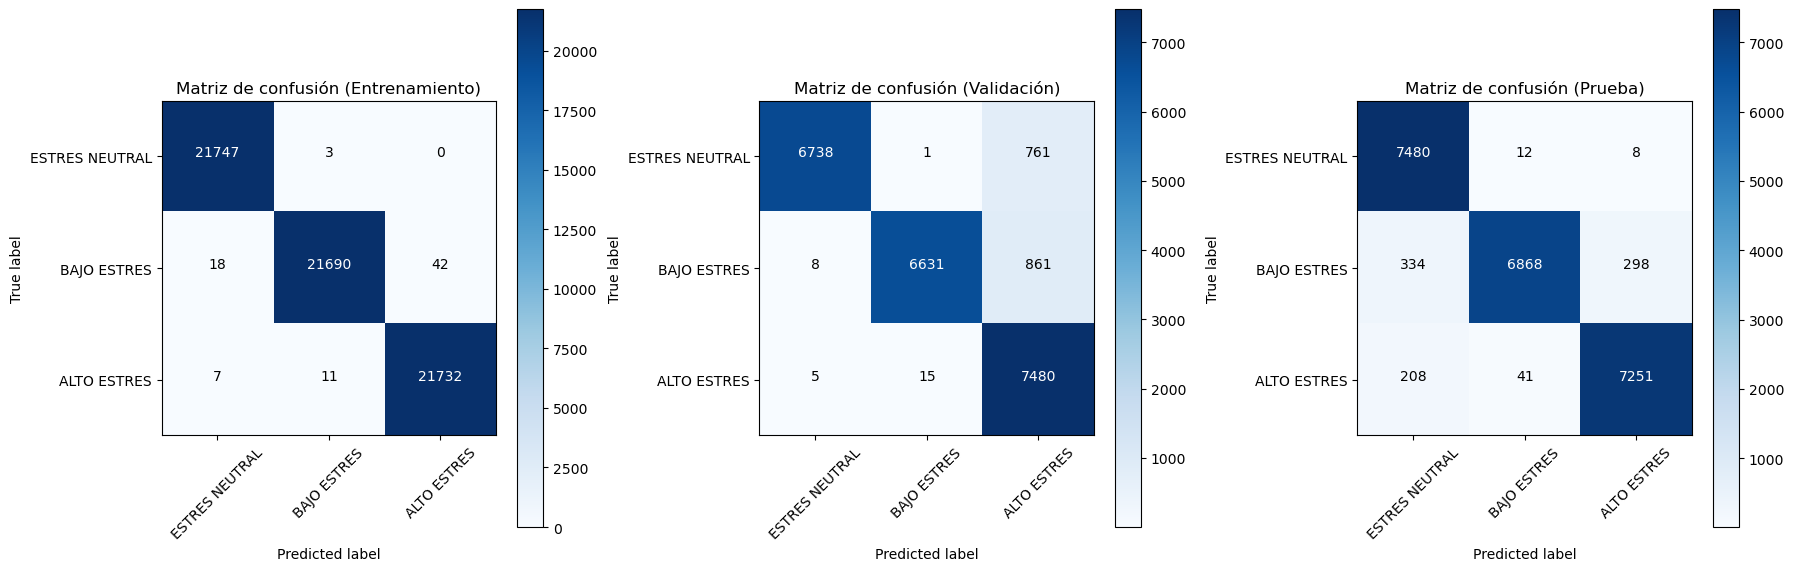

In [ ]:
# Asumiendo que tienes 'model' ya entrenado y 'X_train', 'X_val', 'X_test', 'y_train', 'y_val', 'y_test' definidos
y_pred_train = model.predict(cargar_imagenes(X_train_paths))
y_pred_val = model.predict(cargar_imagenes(X_val_paths))
y_pred_test = model.predict(cargar_imagenes(X_test_paths))

# Convertir las predicciones de probabilidades a etiquetas
y_pred_train_labels = np.argmax(y_pred_train, axis=1)
y_pred_val_labels = np.argmax(y_pred_val, axis=1)
y_pred_test_labels = np.argmax(y_pred_test, axis=1)

# Etiquetas verdaderas
y_true_train = np.argmax(y_train, axis=1)
y_true_val = np.argmax(y_val, axis=1)
y_true_test = np.argmax(y_test, axis=1)


# Calcular matrices de confusión
cm_train = confusion_matrix(y_true_train, y_pred_train_labels)
cm_val = confusion_matrix(y_true_val, y_pred_val_labels)
cm_test = confusion_matrix(y_true_test, y_pred_test_labels)

# Comprobar el orden de las clases
print("Orden de las clases:", etiquetas_dict)

# Dibujar matrices de confusión
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plot_confusion_matrix(cm_train, classes=['ESTRES NEUTRAL', 'BAJO ESTRES', 'ALTO ESTRES'], title='Matriz de confusión (Entrenamiento)')
plt.subplot(1, 3, 2)
plot_confusion_matrix(cm_val, classes=['ESTRES NEUTRAL', 'BAJO ESTRES', 'ALTO ESTRES'], title='Matriz de confusión (Validación)')
plt.subplot(1, 3, 3)
plot_confusion_matrix(cm_test, classes=['ESTRES NEUTRAL', 'BAJO ESTRES', 'ALTO ESTRES'], title='Matriz de confusión (Prueba)')

In [ ]:
# Entrenar el modelo final con todo el conjunto de entrenamiento
X_train_final = cargar_imagenes(X_train_paths)
y_train_final = y_train

# Crear el modelo final
model_final = create_model_4(input_shape, num_classes)

# Compilar el modelo final
model_final.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo final
model_final.fit(X_train_final, y_train_final, epochs=10, batch_size=32, shuffle=True)

# Guardar el modelo final en el formato SavedModel en la carpeta 'modelos'
model_save_path = os.path.join("modelos", 'modelo_final_4.h5')
model_final.save(model_save_path)

Epoch 1/10
2040/2040 [==============================] - 9s 4ms/step - loss: 0.0613 - accuracy: 0.9808
Epoch 2/10
2040/2040 [==============================] - 7s 4ms/step - loss: 0.0365 - accuracy: 0.9877
Epoch 3/10
2040/2040 [==============================] - 8s 4ms/step - loss: 0.0283 - accuracy: 0.9909
Epoch 4/10
2040/2040 [==============================] - 8s 4ms/step - loss: 0.0253 - accuracy: 0.9918
Epoch 5/10
2040/2040 [==============================] - 7s 4ms/step - loss: 0.0211 - accuracy: 0.9929
Epoch 6/10
2040/2040 [==============================] - 7s 3ms/step - loss: 0.0164 - accuracy: 0.9947
Epoch 7/10
2040/2040 [==============================] - 7s 3ms/step - loss: 0.0127 - accuracy: 0.9958
Epoch 8/10
2040/2040 [==============================] - 7s 3ms/step - loss: 0.0107 - accuracy: 0.9964
Epoch 9/10
2040/2040 [==============================] - 8s 4ms/step - loss: 0.0103 - accuracy: 0.9967
Epoch 10/10
2040/2040 [==============================] - 8s 4ms/step - loss: 0.008

#### 3.1.5 Modelo 5

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Convertir etiquetas a one-hot encoding
etiquetas_one_hot = to_categorical(etiquetas_numericas)

# Crear una lista de sujetos únicos
sujetos_unicos = sorted(set(sujetos))
print("Número de sujetos:", len(sujetos_unicos))

# Dividir los sujetos en conjuntos de entrenamiento, validación y prueba
train_suj, test_val_suj = train_test_split(sujetos_unicos, test_size=0.4, random_state=42)
val_suj, test_suj = train_test_split(test_val_suj, test_size=0.5, random_state=42)

# Función para asignar conjunto basado en el sujeto
def asignar_conjunto(sujeto):
    if sujeto in train_suj:
        return 'train'
    elif sujeto in val_suj:
        return 'val'
    else:
        return 'test'

# Asignar cada imagen a un conjunto
conjuntos = np.array([asignar_conjunto(s) for s in sujetos])

# Separar las imágenes y etiquetas en los conjuntos
X_train_paths = np.array(imagenes)[conjuntos == 'train']
y_train = etiquetas_one_hot[conjuntos == 'train']
X_val_paths = np.array(imagenes)[conjuntos == 'val']
y_val = etiquetas_one_hot[conjuntos == 'val']
X_test_paths = np.array(imagenes)[conjuntos == 'test']
y_test = etiquetas_one_hot[conjuntos == 'test']

# Imprimir las formas de los arrays para verificar
print("Datos de entrenamiento:", X_train_paths.shape, y_train.shape)
print("Datos de validación:", X_val_paths.shape, y_val.shape)
print("Datos de prueba:", X_test_paths.shape, y_test.shape)

# Ver cuales son los sujetos que se encuentran en cada conjunto
print("Sujetos de entrenamiento:", sorted(train_suj))
print("Sujetos de validación:", sorted(val_suj))
print("Sujetos de prueba:", sorted(test_suj))



Número de sujetos: 49
Datos de entrenamiento: (65250,) (65250, 3)
Datos de validación: (22500,) (22500, 3)
Datos de prueba: (22500,) (22500, 3)
Sujetos de entrenamiento: ['01', '02', '03', '06', '08', '10', '11', '12', '15', '17', '19', '21', '22', '23', '24', '25', '30', '31', '32', '34', '35', '37', '38', '39', '40', '41', '44', '45', '50']
Sujetos de validación: ['04', '09', '13', '16', '18', '20', '27', '28', '36', '49']
Sujetos de prueba: ['05', '07', '14', '29', '33', '42', '43', '46', '47', '48']


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, LeakyReLU

# Función para crear un modelo con capas ajustadas
def create_model_5(input_shape, num_classes):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(512, input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

input_shape = (256, 7, 7)  # Actualizar según sea necesario
num_classes = 3  # Cambiar según el número de clases en tu dataset

In [ ]:
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Configurar validación cruzada con 5 divisiones
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Variables para almacenar los resultados de la validación cruzada
fold_no = 1
acc_per_fold = []
loss_per_fold = []

# Función para cargar imágenes desde rutas antes de entrenar el modelo
def cargar_imagenes(rutas):
    imagenes = [load_npy_file(ruta) for ruta in rutas]
    return np.array(imagenes)

# Validación cruzada, iterar sobre cada división
for train_index, val_index in kf.split(X_train_paths):
    print(f"Fold número {fold_no}")
    # Usar las divisiones correctas para el entrenamiento y la validación
    X_train_fold_paths, X_val_fold_paths = X_train_paths[train_index], X_train_paths[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    # Cargar las imágenes
    X_train_fold = cargar_imagenes(X_train_fold_paths)
    X_val_fold = cargar_imagenes(X_val_fold_paths)
    
    # Comprobar que las formas son correctas
    print(X_train_fold.shape, y_train_fold.shape)
    print(X_val_fold.shape, y_val_fold.shape)

    # Crear el modelo
    model = create_model_5(input_shape, num_classes)
    
    # Compilar el modelo
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Entrenar el modelo y validar con los datos de validación
    print(f'Training fold {fold_no}...')
    history = model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, validation_data=(X_val_fold, y_val_fold), shuffle=True)
    
    # Evaluar el modelo con los datos de test
    X_test = cargar_imagenes(X_test_paths)
    scores = model.evaluate(X_test, y_test, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Incrementar el número de la división
    fold_no += 1

Fold número 1


(52200, 256, 7, 7) (52200, 3)
(13050, 256, 7, 7) (13050, 3)


2024-07-23 13:14:13.077490: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-23 13:14:13.421264: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-23 13:14:13.421534: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-23 13:14:13.421752: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

Training fold 1...


2024-07-23 13:14:14.370665: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2619187200 exceeds 10% of free system memory.
2024-07-23 13:14:15.902039: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2619187200 exceeds 10% of free system memory.


Epoch 1/10


2024-07-23 13:14:18.184597: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-07-23 13:14:18.198380: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f4d408072d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-23 13:14:18.198393: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-07-23 13:14:18.198397: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2024-07-23 13:14:18.209715: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-23 13:14:18.381673: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is 

1632/1632 [==============================] - 7s 3ms/step - loss: 0.0690 - accuracy: 0.9751 - val_loss: 0.0273 - val_accuracy: 0.9910
Epoch 2/10
1632/1632 [==============================] - 5s 3ms/step - loss: 0.0336 - accuracy: 0.9883 - val_loss: 0.0459 - val_accuracy: 0.9844
Epoch 3/10
1632/1632 [==============================] - 5s 3ms/step - loss: 0.0278 - accuracy: 0.9906 - val_loss: 0.0193 - val_accuracy: 0.9933
Epoch 4/10
1632/1632 [==============================] - 5s 3ms/step - loss: 0.0252 - accuracy: 0.9919 - val_loss: 0.0159 - val_accuracy: 0.9943
Epoch 5/10
1632/1632 [==============================] - 5s 3ms/step - loss: 0.0215 - accuracy: 0.9928 - val_loss: 0.0160 - val_accuracy: 0.9943
Epoch 6/10
1632/1632 [==============================] - 5s 3ms/step - loss: 0.0186 - accuracy: 0.9939 - val_loss: 0.0275 - val_accuracy: 0.9918
Epoch 7/10
1632/1632 [==============================] - 5s 3ms/step - loss: 0.0164 - accuracy: 0.9948 - val_loss: 0.0165 - val_accuracy: 0.9944
Epo

2024-07-23 13:15:26.023672: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2619187200 exceeds 10% of free system memory.
2024-07-23 13:15:27.524755: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2619187200 exceeds 10% of free system memory.


Epoch 1/10
1632/1632 [==============================] - 6s 3ms/step - loss: 0.0700 - accuracy: 0.9741 - val_loss: 0.0339 - val_accuracy: 0.9886
Epoch 2/10
1632/1632 [==============================] - 5s 3ms/step - loss: 0.0327 - accuracy: 0.9890 - val_loss: 0.0218 - val_accuracy: 0.9930
Epoch 3/10
1632/1632 [==============================] - 5s 3ms/step - loss: 0.0265 - accuracy: 0.9907 - val_loss: 0.0201 - val_accuracy: 0.9935
Epoch 4/10
1632/1632 [==============================] - 5s 3ms/step - loss: 0.0241 - accuracy: 0.9920 - val_loss: 0.0177 - val_accuracy: 0.9944
Epoch 5/10
1632/1632 [==============================] - 5s 3ms/step - loss: 0.0212 - accuracy: 0.9929 - val_loss: 0.0151 - val_accuracy: 0.9956
Epoch 6/10
1632/1632 [==============================] - 5s 3ms/step - loss: 0.0184 - accuracy: 0.9935 - val_loss: 0.0172 - val_accuracy: 0.9954
Epoch 7/10
1632/1632 [==============================] - 4s 3ms/step - loss: 0.0176 - accuracy: 0.9941 - val_loss: 0.0153 - val_accuracy:

2024-07-23 13:16:33.368609: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2619187200 exceeds 10% of free system memory.


Epoch 1/10
1632/1632 [==============================] - 6s 3ms/step - loss: 0.0699 - accuracy: 0.9741 - val_loss: 0.0228 - val_accuracy: 0.9923
Epoch 2/10
1632/1632 [==============================] - 4s 3ms/step - loss: 0.0325 - accuracy: 0.9891 - val_loss: 0.0207 - val_accuracy: 0.9932
Epoch 3/10
1632/1632 [==============================] - 5s 3ms/step - loss: 0.0265 - accuracy: 0.9914 - val_loss: 0.0178 - val_accuracy: 0.9943
Epoch 4/10
1632/1632 [==============================] - 5s 3ms/step - loss: 0.0238 - accuracy: 0.9920 - val_loss: 0.0181 - val_accuracy: 0.9941
Epoch 5/10
1632/1632 [==============================] - 5s 3ms/step - loss: 0.0208 - accuracy: 0.9929 - val_loss: 0.0188 - val_accuracy: 0.9938
Epoch 6/10
1632/1632 [==============================] - 5s 3ms/step - loss: 0.0181 - accuracy: 0.9942 - val_loss: 0.0274 - val_accuracy: 0.9920
Epoch 7/10
1632/1632 [==============================] - 4s 3ms/step - loss: 0.0166 - accuracy: 0.9945 - val_loss: 0.0166 - val_accuracy:

In [ ]:
# Mostrar los resultados de la validación cruzada
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

# Reiniciar las variables para almacenar los resultados de la validación cruzada de otro modelo
fold_no = 1
acc_per_fold = []
loss_per_fold = []

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.14290322363376617 - Accuracy: 97.64888882637024%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.17470914125442505 - Accuracy: 97.07555770874023%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.11956825852394104 - Accuracy: 96.69333100318909%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.09131768345832825 - Accuracy: 97.97333478927612%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.13977451622486115 - Accuracy: 97.53777980804443%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 97.38577842712402 (+- 0.4501720359434397)
> Loss: 0.13365456461906433
----------------------

704/704 [==============================] - 1s 1ms/step
Orden de las clases: {'ESTRES NEUTRAL': 0, 'BAJO ESTRES': 1, 'ALTO ESTRES': 2}


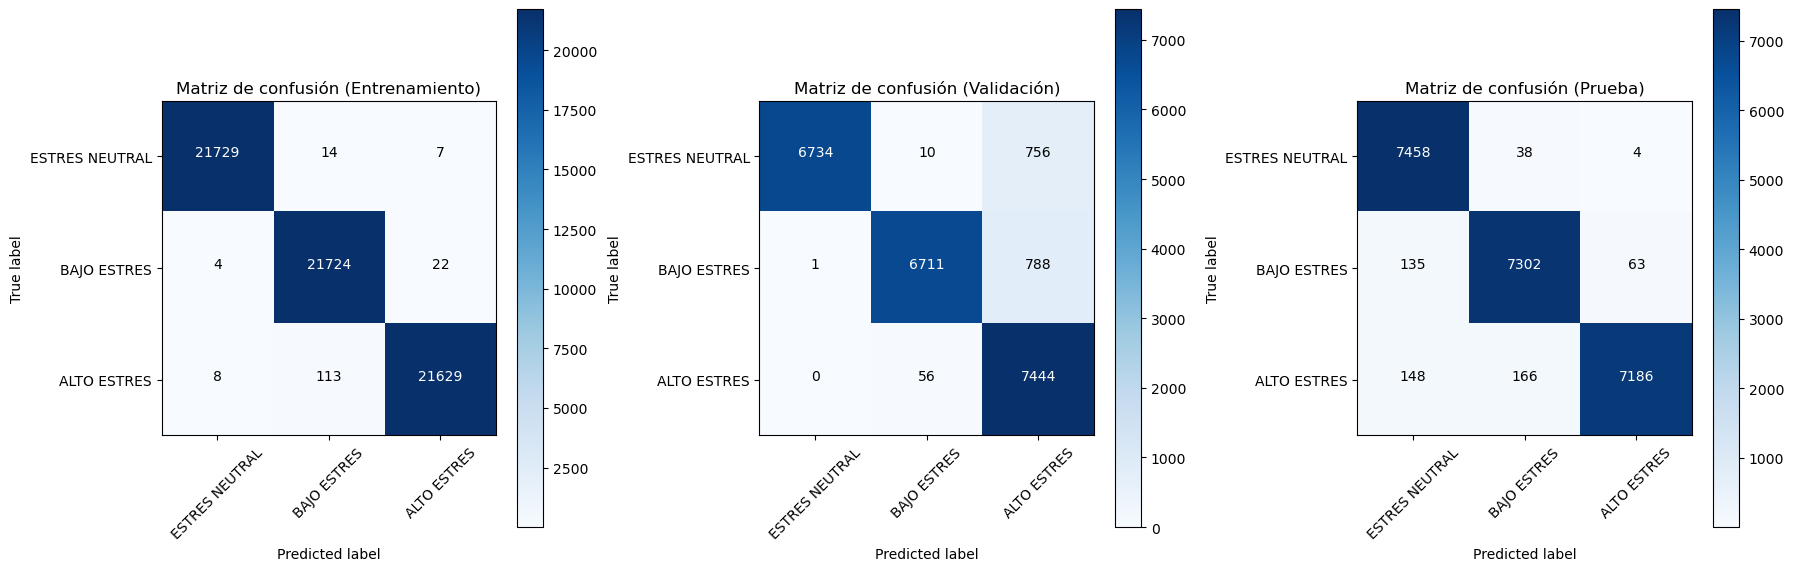

In [ ]:
# Asumiendo que tienes 'model' ya entrenado y 'X_train', 'X_val', 'X_test', 'y_train', 'y_val', 'y_test' definidos
y_pred_train = model.predict(cargar_imagenes(X_train_paths))
y_pred_val = model.predict(cargar_imagenes(X_val_paths))
y_pred_test = model.predict(cargar_imagenes(X_test_paths))

# Convertir las predicciones de probabilidades a etiquetas
y_pred_train_labels = np.argmax(y_pred_train, axis=1)
y_pred_val_labels = np.argmax(y_pred_val, axis=1)
y_pred_test_labels = np.argmax(y_pred_test, axis=1)

# Etiquetas verdaderas
y_true_train = np.argmax(y_train, axis=1)
y_true_val = np.argmax(y_val, axis=1)
y_true_test = np.argmax(y_test, axis=1)


# Calcular matrices de confusión
cm_train = confusion_matrix(y_true_train, y_pred_train_labels)
cm_val = confusion_matrix(y_true_val, y_pred_val_labels)
cm_test = confusion_matrix(y_true_test, y_pred_test_labels)

# Comprobar el orden de las clases
print("Orden de las clases:", etiquetas_dict)

# Dibujar matrices de confusión
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plot_confusion_matrix(cm_train, classes=['ESTRES NEUTRAL', 'BAJO ESTRES', 'ALTO ESTRES'], title='Matriz de confusión (Entrenamiento)')
plt.subplot(1, 3, 2)
plot_confusion_matrix(cm_val, classes=['ESTRES NEUTRAL', 'BAJO ESTRES', 'ALTO ESTRES'], title='Matriz de confusión (Validación)')
plt.subplot(1, 3, 3)
plot_confusion_matrix(cm_test, classes=['ESTRES NEUTRAL', 'BAJO ESTRES', 'ALTO ESTRES'], title='Matriz de confusión (Prueba)')

In [ ]:
# Entrenar el modelo final con todo el conjunto de entrenamiento
X_train_final = cargar_imagenes(X_train_paths)
y_train_final = y_train

# Crear el modelo final
model_final = create_model_5(input_shape, num_classes)

# Compilar el modelo final
model_final.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo final
model_final.fit(X_train_final, y_train_final, epochs=10, batch_size=32, shuffle=True)

# Guardar el modelo final en el formato SavedModel en la carpeta 'modelos'
model_save_path = os.path.join("modelos", 'modelo_final_5.h5')
model_final.save(model_save_path)

Epoch 1/10
2040/2040 [==============================] - 6s 3ms/step - loss: 0.0631 - accuracy: 0.9782
Epoch 2/10
2040/2040 [==============================] - 5s 3ms/step - loss: 0.0308 - accuracy: 0.9897
Epoch 3/10
2040/2040 [==============================] - 5s 3ms/step - loss: 0.0247 - accuracy: 0.9918
Epoch 4/10
2040/2040 [==============================] - 5s 3ms/step - loss: 0.0224 - accuracy: 0.9927
Epoch 5/10
2040/2040 [==============================] - 5s 3ms/step - loss: 0.0200 - accuracy: 0.9937
Epoch 6/10
2040/2040 [==============================] - 5s 3ms/step - loss: 0.0176 - accuracy: 0.9944
Epoch 7/10
2040/2040 [==============================] - 5s 3ms/step - loss: 0.0168 - accuracy: 0.9943
Epoch 8/10
2040/2040 [==============================] - 5s 3ms/step - loss: 0.0160 - accuracy: 0.9946
Epoch 9/10
2040/2040 [==============================] - 5s 3ms/step - loss: 0.0138 - accuracy: 0.9955
Epoch 10/10
2040/2040 [==============================] - 5s 3ms/step - loss: 0.012